### Requirements

In [17]:
import pandas as pd
import numpy as np
import bz2
import json
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import requests
import findspark
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

### PySpark
Since the datasets have an important size, we've decided to use pyspark in order to parse or analyze the data. Sometimes we only focus on some columns so we can "go back" to pandas dataframes.

In [18]:
# Create a spark context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [19]:
# Read JSON file and put it in a pyspark dataframe.
df = spark.read.json('data/quotes-2020.json.bz2')

In [4]:
df.show(5)

+-------------------+--------------+-----+--------------------+-----------+--------------------+-----------------+-------------------+--------------------+
|               date|numOccurrences|phase|              probas|       qids|           quotation|          quoteID|            speaker|                urls|
+-------------------+--------------+-----+--------------------+-----------+--------------------+-----------------+-------------------+--------------------+
|2020-01-28 08:04:05|             1|    E|[[None, 0.7272], ...|         []|[ D ] espite the ...|2020-01-28-000082|               None|[http://israelnat...|
|2020-01-16 12:00:13|             1|    E|[[Sue Myrick, 0.8...|  [Q367796]|[ Department of H...|2020-01-16-000088|         Sue Myrick|[http://thehill.c...|
|2020-02-10 23:45:54|             1|    E|[[None, 0.8926], ...|         []|... He (Madhav) a...|2020-02-10-000142|               None|[https://indianex...|
|2020-02-15 14:12:51|             2|    E|[[None, 0.581], [...| 

### Formats of the data
#### Summary Columns
- **quoteID**:      Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
- **quotation**:    Text of the longest encountered original form of the quotation
- **speaker**:      Selected most likely speaker
- **qids**:         Wikidata IDs of all aliases that match the selected speaker
- **date**:         Earliest occurrence date of any version of the quotation
- **numOccurences**:Number of time this quotation occurs in the articles
- **probas**:       Array representing the probabilities of each speaker having uttered the quotation
- **urls**:         List of links to the original articles containing the quotation
- **phase**:        Corresponding phase of the data in which the quotation first occurred (A-E)
- **domains**:      Domain of the URL 

We can see using the printSchema function the description of each columns (name, type)

In [5]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- numOccurrences: long (nullable = true)
 |-- phase: string (nullable = true)
 |-- probas: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- qids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quotation: string (nullable = true)
 |-- quoteID: string (nullable = true)
 |-- speaker: string (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: string (containsNull = true)



An interesting view to have is the overall distribution of speakers, and which are the most represented, by counting thier number of occurences.

We want to analyse whether there are errors in the columns, that would show if a null value would appear in one of the columns. Thus, we check each column for such an error. However, we do not check the Speakers column, it is natural to find None values, occuring when Quootstrap did not find an appropriate speaker for the quote

In [ ]:
df.filter(df.date == None).show()
df.filter(df.numOccurrences == None).show()
df.filter(df.phase == None).show()
df.filter(df.probas == None).show()
df.filter(df.qids == None).show()
df.filter(df.quotation == None).show()
df.filter(df.quoteID == None).show()
df.filter(df.speaker == None).show()
df.filter(df.urls == None).show()

However, a way to check the integrity of the speakers is to compare the attributed speaker to the one with the highest probability as indicated in the probas column. In the meantime, we compare the ditribution of the overall speakers 

In [20]:
temp = df.select(df.speaker, df.probas)
temp = temp.withColumn("highest_prob", temp.probas[0])
temp = temp.withColumn("prob_speaker", temp.highest_prob[0])

error_speakers = temp.filter(temp.speaker != temp.prob_speaker)
error_speakers.show(30)

+-----------------+--------------------+--------------------+--------------------+
|          speaker|              probas|        highest_prob|        prob_speaker|
+-----------------+--------------------+--------------------+--------------------+
|             None|[[Kris Bryant, 0....|[Kris Bryant, 0.4...|         Kris Bryant|
|         Jane Roe|[[None, 0.2695], ...|      [None, 0.2695]|                None|
| Christian Doidge|[[None, 0.1002], ...|      [None, 0.1002]|                None|
|     Heidi Larson|[[None, 0.0614], ...|      [None, 0.0614]|                None|
|             None|[[Rio Ferdinand, ...|[Rio Ferdinand, 0...|       Rio Ferdinand|
|             None|[[Paul Brown, 0.3...|[Paul Brown, 0.3887]|          Paul Brown|
|     Joel Dommett|[[None, 0.0367], ...|      [None, 0.0367]|                None|
|        Ed Turner|[[None, 0.0172], ...|      [None, 0.0172]|                None|
|      Peter Weber|[[None, 0.3477], ...|      [None, 0.3477]|                None|
|   

In [21]:
WrongSpeakers = error_speakers.groupBy("prob_speaker").count()
asc_wrong = WrongSpeakers.sort("count", ascending = False)

overall_speakers = temp.groupBy("prob_speaker").count()
asc_overall = overall_speakers.sort("count", ascending = False)

In [22]:
overall = asc_overall.toPandas()
wrong = asc_wrong.toPandas()

Text(0.5, 1.0, 'Distribution of the most cited people in the dataset overall')

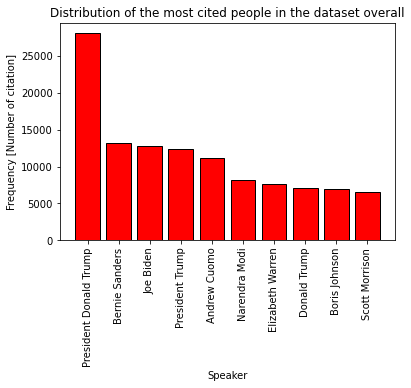

In [23]:
overall = overall[1:11]

fig = plt.figure()
plt.bar(overall["prob_speaker"], overall["count"], color = 'r', ec='black')
plt.xlabel('Speaker')
plt.xticks(rotation = "vertical")
plt.ylabel('Frequency [Number of citation]')
plt.title('Distribution of the most cited people in the dataset overall')

Text(0.5, 1.0, 'Distribution of the most cited people in the dataset in misatributed speakers ')

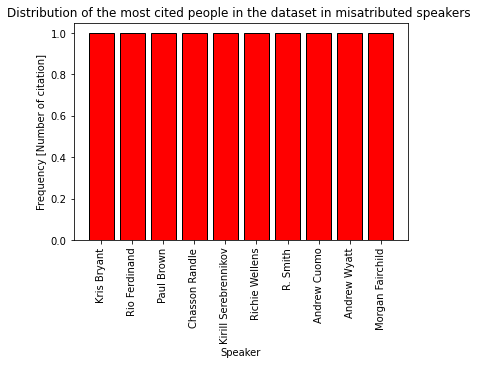

In [24]:
wrong = wrong[1:11]

fig = plt.figure()
plt.bar(wrong["prob_speaker"], wrong["count"], color = 'r', ec='black')
plt.xlabel('Speaker')
plt.xticks(rotation = "vertical")
plt.ylabel('Frequency [Number of citation]')
plt.title('Distribution of the most cited people in the dataset in misatributed speakers ')

As we can expect, the most cited speakers are ones that are the most talked about depending on the events of the year. In the 2020 dataset, we find the quotes relating to the american elections, and we see that the most cited speakers are almost all the ones more or less related to them, exept for Narendra Modi, most likely appearing because of the global unrest in india during 2020.
As far as the "misslabeled" datapoints, we do not see any specific pattern. Every speaker that is misslabeled is so only once

### Statistics
In order to analyse the statistics of some columns we used the function summary. We only kept the statics that are relevants. For the example the percentiles are not really meaningful for the quotation since the column contain only words. 

In [6]:
# Est ce que cette ligne pourrait être utile ? 
df.select('numOccurrences').summary('count','mean','stddev','min','max').show()

+-------+------------------+
|summary|    numOccurrences|
+-------+------------------+
|  count|           5244449|
|   mean|3.2820887380161388|
| stddev|13.983172414380137|
|    min|                 1|
|    25%|                 1|
|    50%|                 1|
|    75%|                 2|
|    max|              9210|
+-------+------------------+



To simplify the tasks, we will use a specific event that will allow us to compute faster and try our methods. We take here a simple example, the win at the 92 academy awards of the widely acclaimed korean film "Parasite". We do this since it is relatively easy to filter the quotes about it, by searching for the word "Parasite".

In [90]:
df_parasite = df.filter(df.quotation.contains('Parasite'))

parasite = df_parasite.toPandas()
parasite_words = parasite.iloc[:,5]

splitted = []

for sub in parasite_words:
    for wrd in sub.split():
        splitted.append(wrd)

In [ ]:
df_australia.show()

At the level of Quotes, since we want to capture the essence of the words, we need to filter a bit the data. First, we will need to get rid of the "common" words that do not contribute much to the actual meaning of the sentence and have a risk of overshadowing the relevant information. 

In [91]:
counter_paras = Counter(splitted)
most_occur = counter_paras.most_common(100)
  
print(most_occur)

[('the', 757), ('and', 441), ('a', 353), ('to', 334), ('of', 333), ('I', 298), ('is', 264), ('in', 218), ('that', 211), ('Parasite', 196), ('for', 135), ("`Parasite'", 120), ('film', 111), ('with', 111), ('are', 99), ('it', 98), ('have', 85), ('was', 84), ('be', 83), ('The', 78), ('on', 76), ('we', 75), ('as', 75), ('about', 72), ('but', 70), ('all', 68), ('from', 68), ('has', 68), ('this', 66), ('think', 65), ('Korean', 63), ('an', 61), ('so', 60), ('at', 60), ('not', 58), ('like', 58), ('Parasite,', 55), ('you', 54), ('best', 52), ('can', 51), ('how', 47), ('really', 43), ("it's", 43), ("It's", 43), ('Bong', 42), ('movie', 41), ('people', 41), ('or', 41), ('--', 40), ('very', 40), ('will', 39), ('[', 38), ('just', 38), ('see', 34), ('It', 34), ('one', 34), ('world', 34), ('my', 34), ('by', 33), ('more', 33), ('if', 33), ('films', 32), ("I'm", 32), ('also', 31), ('time', 30), ('win', 30), (']', 30), ('into', 29), ('been', 29), ('our', 28), ('out', 27), ('its', 26), ('which', 26), ('An

We see that indeed, even in this small subset, we have predominant nonimportant words. To then extract relevant words, we can use the TF-IDF method, which is an information retrieval technique that produces a value that increases depending on how many time it is cited in a document, but also decreases the more it is present in different documents.

In [92]:
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in splitted if not w.lower() in stop_words]
print("There are in the unfiltered subset:",len(splitted), "words")
print("There are in the filtered subset:", len(filtered_sentence), "words")

There are in the unfiltered subset: 14958 words
There are in the filtered subset: 8203 words


In [185]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_sentence)
print("There are" ,len(vectorizer.get_feature_names()), "important words according to this filtering")

tfid = vectorizer.fit_transform(parasite_words)
pairwise_similarity = (tfid * tfid.T).toarray()

duplicates_id = []
i = 0
for quote in pairwise_similarity:
    for val in range(i, len(quote)):
        if (quote[val] > 0.7) and (i != val):

            duplicates_id.append(val)
    i += 1

duplicates_id = list(set(duplicates_id))
duplicates_id.sort()

pruned_parasite_words = np.delete(np.array(parasite_words), np.array(duplicates_id))

There are 2323 important words according to this filtering


We see that we have some interesting information, but still have quite a large amount of words. We might need to filter accoring to specific criteria to direct the search

Now, we want to capture the essence of the different quotes, which we can do using what is called sentiment analysis. We can use the NLTK python library, which has a sentiment analyser built in called VADER. It is a rough version, more oriented on anaylsing short tweets, but it can serve as a good indication on whether it is possible to capture the essence of quotes, and then see the most occuring words.

In [188]:
sia = SentimentIntensityAnalyzer()

pos_quotes = []
neg_quotes = []

for i in range(0, len(parasite_words)):
    
    humor = sia.polarity_scores(parasite_words[i])
    if humor["pos"] > 0.4:
        pos_quotes.append(parasite_words[i])
    elif humor["neg"] > 0.4:
        neg_quotes.append(parasite_words[i])

print("The mostly positive quotes are: \n", pos_quotes[0:5])
print("The mostly negative quotes are: \n", neg_quotes[0:5])

The mostly positive quotes are: 
 ["' Parasite' is not only the first Korean film, but also the first Korean content overall to win a Golden Globe... We hope the film industry and all audiences that love Korean cinema will celebrate this good news,", "I was so happy to see `Parasite' won. It is a great work, and painted the gap between the rich and the poor very well,", "Although the title is Parasite, I think the story is about co-existence and how we can all live together. But to be honored with the best ensemble award, it occurs to me that maybe we haven't created such a bad movie. I'm so honored to receive this award in front of such amazing actors that I admire. I will never forget this beautiful night. Thank you so much.", "' Parasite' makes Oscars history as the first foreign-language film to win best picture", "We're not only celebrating `Parasite,' but how a foreign movie just won best picture, the biggest award,"]
The mostly negative quotes are: 
 ["`Parasite' Explores What L

We see that though it is quite basic, it gives a good idea of the feeling of certain quotes. In this case, the movie in itself has grim themes, which the algorithm confuses for negative emotions. Given that it is possible to "improve" VADER, depending on the events we can find new words associated with negative and positive emotions, to help it recognize the sentences in this context and find keywords of those sentiments. For example, in the case of a movie, a negative word that is not widely recognized as such would be "overrated".

In [184]:
substring_in_list = [s for s in pruned_parasite_words if "Overrated" in s]
print(substring_in_list)

["Bong Joon-ho's `Parasite' Is Overrated, Implausible, Class-Struggle Nonsense."]


We see that indeed, some sentences that are not picked up by VADER are actually negative towards the movie, showing that we need to tune the algorithm for each event

We also want to see if it is possible to map the quotes in time by extracting the dates of the date column. We do not take much interest in the minutes since the timescales we want to map are much larger than this. We take the quotes uttered in january, february and march, since, the release of the 

In [96]:
parasite['date'] = parasite['date'].str.split(r' ').str.get(0)
parasite['month'] = parasite['date'].str.split(r'-').str.get(1)
parasite['day'] = parasite['date'].str.split(r'-').str.get(2)

In [107]:
grouped = parasite.groupby(['month'])
jan = grouped.get_group('01').sort_values(by = 'day')
feb = grouped.get_group('02').sort_values(by = 'day')
mar = grouped.get_group('03').sort_values(by = 'day')

def positive_negative(timeframe, param = "quotation"):
    
    positive_quotes = []
    negative_quotes = []
    
    for line in timeframe[param]:
    
        humor = sia.polarity_scores(line)

        if humor["pos"] > 0.4:
            positive_quotes.append(line)
        elif humor["neg"] > 0.4:
            negative_quotes.append(line)
        
    return [positive_quotes, negative_quotes]

humor_jan = positive_negative(jan)
print("In january 2020, there were", len(humor_jan[0]), "positive quotes and", len(humor_jan[1]), "negative quotes")

humor_feb = positive_negative(feb)
print("In february 2020, there were", len(humor_feb[0]), "positive quotes and", len(humor_feb[1]), "negative quotes")

humor_mar = positive_negative(mar)
print("In march 2020, there were", len(humor_mar[0]), "positive quotes and", len(humor_mar[1]), "negative quotes")


In january 2020, there were 10 positive quotes and 1 negative quotes
In february 2020, there were 40 positive quotes and 3 negative quotes
In march 2020, there were 0 positive quotes and 1 negative quotes


Though quite rudimentary, we see that indeed the quotes reflect the trends, with an increase in activity around the actual event.

**Analysing Selected Speaker vs Highest Probablity Speaker**

Comparing the speaker in the "speaker" column against the one with the highest probability in "probas", outputing the lines with different values for those two, and counting the number of occurences, displaying the highest ones

**Analysing Columns**

Checking for aberrent values in the dataset, each column separately

**Analysing Number of Occurences**

Looking at the most occuring Quotes

In [177]:
ordered_occurences = df.sort("numOccurrences", ascending = False).show()

+-------------------+--------------+-----+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+
|               date|numOccurrences|phase|              probas|                qids|           quotation|          quoteID|          speaker|                urls|
+-------------------+--------------+-----+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+
|2020-02-28 14:08:52|          9210|    E|[[None, 0.6861], ...|                  []|something we talk...|2020-02-28-057818|             None|[http://www.gamer...|
|2020-01-23 00:00:00|          8257|    E|[[None, 0.5039], ...|                  []|continue to vigor...|2020-01-23-014909|             None|[http://www.gamer...|
|2020-01-08 00:00:00|          4624|    E|[[None, 0.7055], ...|                  []|as fast as we hum...|2020-01-08-006926|             None|[https://www.game...|
|2020-03-26 13:45:24| 

#### First analysis of the speaker column
We first started be creating a file containing only the speakers. The we loaded the new file in a pandas dataframe. 

In [9]:
path_to_file = 'data/quotes-2020.json.bz2' 
path_to_out = 'data/speakers-2020.txt.bz2'
with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wt') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            speaker = sp = instance['speaker']
            if sp[0] != 'None':
                d_file.write(speaker+'\n')# writing in the new file

In [11]:
data_speaker = pd.read_csv('data/speakers-2020.txt.bz2', sep="\n", header=None)
data_speaker = data_speaker[data_speaker[0] !='None'].drop_duplicates()
data_speaker

,0
1,Sue Myrick
4,Meghan King Edmonds
7,Dexter Smith
8,Barry Coppinger
9,Ben Carson
...,...
5243953,Jackie Northam
5244009,Taavi Rõivas
5244044,Yu Jin
5244161,Eoin McGrath


There is for the 2020's dataset, 218,414 different speakers, it seems to be still a big number. We decided to look more into detail. We used Donald Trump as an example to begin our analysis.

In [14]:
df_trump = data_speaker.loc[data_speaker[0].str.contains('Trump',case = False)]
df_trump = df_trump.drop_duplicates()
searchfor = ['Melania', 'Eric','Ivanka','judd','trumpauer','Barron','Lara','Andreas','william','trumper','spencer','blaine','charles','ivana']
df_trump = df_trump[~df_trump[0].str.contains('|'.join(searchfor),case = False)]
df_trump

,0
247,Donald Trump
263,President Donald Trump
609,President Trump
13688,Donald Trump Jr. .
15578,Donald Trump Jr
16328,"Donald Trump , Jr. ."
16448,Donald J. Trump
27659,President Donald J. Trump
31087,Donald trump
38768,president Donald Trump


In [32]:
df[df.speaker.isin('president Donald John Trump','donald Trump')].show()

+-------------------+--------------+-----+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+
|               date|numOccurrences|phase|              probas|               qids|           quotation|          quoteID|             speaker|                urls|
+-------------------+--------------+-----+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+
|2020-03-03 00:00:00|             1|    E|[[donald Trump, 0...|[Q22686, Q27947481]|We need to have h...|2020-03-03-070897|        donald Trump|[http://kut.org/p...|
|2020-03-24 21:59:21|             1|    E|[[president Donal...|           [Q22686]|As we near the en...|2020-03-24-006609|president Donald ...|[https://boingboi...|
+-------------------+--------------+-----+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+



There are 35 different names for Donald Trump, in lower and upper cases. If we want, we could try to "clean" this problem but it would take too much time and it would be only for the aesthetic side. The good news is that all the different names for Donald Trump have the same QIDS. We will then use this column for any future analysis or comparison/joining we need to do. 

A second thing that we wanted to analyse is if there were speakers name that we "not normal". For this we check for speakers name that contain speacial character and also speakers name that have a size longer than usual (~might be a sentence)

In [33]:
data_speaker['len'] = data_speaker[0].apply(lambda x : len(x.split()))
data_speaker[data_speaker['len'] >= 8]

,0,len
149342,Sister Teresa Joseph Patrick of Jesus and Mary,8
1945236,Hey That 's No Way to Say Goodbye,8


In [35]:
df[df.speaker == "Hey That 's No Way to Say Goodbye"].show()

+-------------------+--------------+-----+--------------------+-----------+--------------------+-----------------+--------------------+--------------------+
|               date|numOccurrences|phase|              probas|       qids|           quotation|          quoteID|             speaker|                urls|
+-------------------+--------------+-----+--------------------+-----------+--------------------+-----------------+--------------------+--------------------+
|2020-03-25 17:20:05|             1|    E|[[Hey That 's No ...|[Q27942120]|Never trust the M...|2020-03-25-047483|Hey That 's No Wa...|[https://www.theg...|
|2020-03-25 17:20:05|             1|    E|[[Hey That 's No ...|[Q27942120]|I still believe i...|2020-03-25-027071|Hey That 's No Wa...|[https://www.theg...|
|2020-03-25 17:20:05|             1|    E|[[Hey That 's No ...|[Q27942120]|I'd hitch hike ar...|2020-03-25-030221|Hey That 's No Wa...|[https://www.theg...|
|2020-03-25 17:20:05|             1|    E|[[Hey That 's No

In [34]:
df_speacial_cases = data_speaker.loc[data_speaker[0].str.contains("''",case = False)].drop_duplicates()
df_speacial_cases

,0,len
16887,Philip `` Brave '' Davis,5
18367,Nicole `` Snooki '' Polizzi,5
28771,Steve `` Lips '' Kudlow,5
30179,Kent `` Smallzy '' Small,5
50412,Jake `` The Snake '' Roberts,6
...,...,...
4152740,`` Rowdy '' Roddy Piper,5
4283614,Jim `` The Anvil '' Neidhart,6
4473694,Judd `` Chip '' Lynn,5
4713229,Leon `` Ndugu '' Chancler,5


We found the speaker "Hey That 's No Way to Say Goodbye". The first thing we can see is that it is a sentence. However we notice that this speaker has a QIDS and if we search on google its QIDS we discover that it is a song written by Leonard Cohen. We will then have to take into account in our analysis that sometimes the speakers are not necessarily real people and may have to do an additional filtering.
It seems Some speakers name contain speacial character that could be removed but it's again something more "esthetic" than pratical for our project. 

We have modified the given code to take for example only the name of the speaker, his QIDS, the quote in order to reduce the size of the dataset we would like to analyze. This will allow us to go faster too. 

In [ ]:
path_to_file = 'data/quotes-2020.json.bz2' 
path_to_out = 'data/sp_qids_quotes-2020.txt.bz2'
k =0
with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wt') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            sp = sp = [instance['speaker'],instance['qids'],instance['quotation']]
            if sp[0] != 'None':
                d_file.write(sp[0]+'\t'+sp[1][0]+'\t'+sp[2]+'\n')# writing in the new file

Now we load the speaker_attributes.parquet file to find more information about the speakers. We notice that often in the columns there are not words but once again QIDS. We tried to find the "labels" (as defined on Wikidata) of these QIDS but without success. This is an important step in our project, especially to be able to interpret our results because the rest of the time, the analysis can easily be done with the QIDS as for the speakers' QIDS for example 

In [38]:
df_speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
df_speaker_attributes.head(10)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
5,"[Augusto Pinochet Ugarte, Augusto José Ramón P...",[+1915-11-25T00:00:00Z],[Q298],[Q6581097],1392242213,None,None,"[Q189290, Q82955]",[Q327591],None,Q368,Augusto Pinochet,None,item,[Q1841]
6,"[Baudelaire, Charles Pierre Baudelaire-Dufaÿs,...",[+1821-04-09T00:00:00Z],[Q142],[Q6581097],1386699038,[Q121842],None,"[Q49757, Q4164507, Q11774202, Q333634, Q36180,...",None,None,Q501,Charles Baudelaire,None,item,[Q1841]
7,"[Mikołaj Kopernik, Nikolaus Kopernikus, Copern...",[+1473-02-19T00:00:00Z],[Q1649871],[Q6581097],1394975677,[Q1026],None,"[Q11063, Q185351, Q188094, Q170790, Q16012028,...",None,None,Q619,Nicolaus Copernicus,None,item,[Q1841]
8,"[Neil Percival Young, Shakey, Godfather of Gru...",[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
9,None,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [39]:
occupations = df_speaker_attributes['occupation'].explode('occupation').drop_duplicates()
occupations.shape[0]

14576

Finally we notice that there are more than 14'500 occupations, we will have to see when we can have their label, if we can group them together to facilitate our analysis. 